In [91]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
cardiotocography = fetch_ucirepo(id=193) 
  
# data (as pandas dataframes) 
X = cardiotocography.data.features 
y = cardiotocography.data.targets 
  
# metadata 
print(cardiotocography.metadata) 
  
# variable information 
print(cardiotocography.variables) 


{'uci_id': 193, 'name': 'Cardiotocography', 'repository_url': 'https://archive.ics.uci.edu/dataset/193/cardiotocography', 'data_url': 'https://archive.ics.uci.edu/static/public/193/data.csv', 'abstract': 'The dataset consists of measurements of fetal heart rate (FHR) and uterine contraction (UC) features on cardiotocograms classified by expert obstetricians.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 2126, 'num_features': 21, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['CLASS', 'NSP'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2000, 'last_updated': 'Fri Mar 15 2024', 'dataset_doi': '10.24432/C51S4N', 'creators': ['D. Campos', 'J. Bernardes'], 'intro_paper': None, 'additional_info': {'summary': '2126 fetal cardiotocograms (CTGs) were automatically processed and the respective diagnostic features measured. The CTGs were also classified

Para o NSP: normal=1; suspeito=2; patológico=3

In [92]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.concat([X, y], axis=1)

df.head()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,CLASS,NSP
0,120,0.000,0.0,0.000,0.000,0.0,0.0,73,0.5,43,...,126,2,0,120,137,121,73,1,9,2
1,132,0.006,0.0,0.006,0.003,0.0,0.0,17,2.1,0,...,198,6,1,141,136,140,12,0,6,1
2,133,0.003,0.0,0.008,0.003,0.0,0.0,16,2.1,0,...,198,5,1,141,135,138,13,0,6,1
3,134,0.003,0.0,0.008,0.003,0.0,0.0,16,2.4,0,...,170,11,0,137,134,137,13,1,6,1
4,132,0.007,0.0,0.008,0.000,0.0,0.0,16,2.4,0,...,170,9,0,137,136,138,11,1,2,1


# Vizualização dos dados

<Axes: xlabel='NSP', ylabel='Count'>

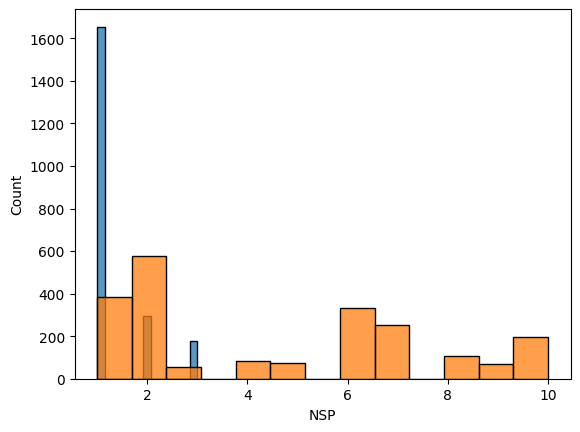

In [93]:
import seaborn as sns

sns.histplot(data=df, x="NSP")
sns.histplot(data=df, x="CLASS")

Não há uma distribuição normal e a base está bastante desbalanceada para o nosso target (NSP).

<Axes: xlabel='CLASS', ylabel='NSP'>

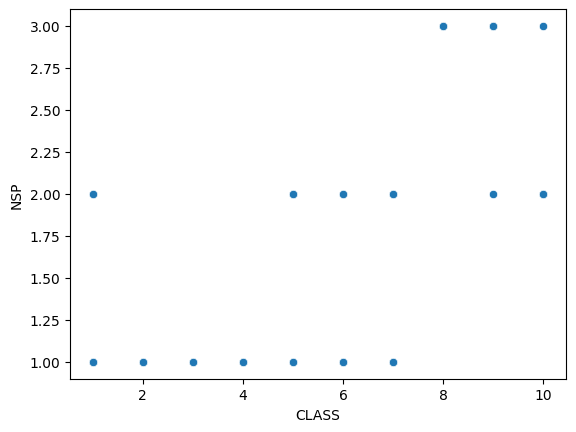

In [94]:
sns.scatterplot(x="CLASS", y="NSP", data=df)

In [95]:
import plotly.express as px

# Supondo que seu DataFrame df esteja definido corretamente
# df = pd.DataFrame(...)

correlation_matrix = df.corr(method='spearman')

fig = px.imshow(correlation_matrix,
                labels=dict(color="Correlation"),
                x=correlation_matrix.columns,
                y=correlation_matrix.columns,
                color_continuous_scale='RdBu_r',
                aspect="auto")

fig.update_layout(title='Mapa de Calor da Matriz de Correlação')

fig.show()


# KNN

In [96]:
X = df.drop(columns=['NSP'])
y = df['NSP']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

In [97]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train, y_train)

# Cross validation para os dados de treino
cv_scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='roc_auc_ovo_weighted')

print("ROC AUC dos folds:", cv_scores)
print("ROC AUC médio:", np.mean(cv_scores))
print("Desvio padrão:", np.std(cv_scores))

ROC AUC dos folds: [0.88412872 0.92417227 0.93658161 0.91453172 0.94135298 0.90652358
 0.92580998 0.966272   0.95943319 0.95589873]
ROC AUC médio: 0.9314704780835437
Desvio padrão: 0.02439139746511527


In [98]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_neighbors': [3, 5, 8, 10, 12, 15, 18, 20],
    'weights': ['uniform', 'distance']
}

grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1, scoring='roc_auc_ovo_weighted')

grid_search.fit(X_train, y_train)

print("Melhor ROC AUC:", grid_search.best_score_)
print("Melhor parâmetro:", grid_search.best_params_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Melhor ROC AUC: 0.9462284249641061
Melhor parâmetro: {'n_neighbors': 12, 'weights': 'distance'}


In [99]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

best_model = grid_search.best_estimator_

# Probabilidade de cada classe para uma entrada
y_prob_bin = best_model.predict_proba(X_test)

# Criação dos dummies pois a curva roc usa dados binários
y_test_bin = label_binarize(y_test, classes=np.unique(y))

roc_auc = roc_auc_score(y_test_bin, y_prob_bin, multi_class='ovo', average='macro')
print("ROC AUC do melhor modelo no conjunto de teste:", roc_auc)


ROC AUC do melhor modelo no conjunto de teste: 0.9561511494776417


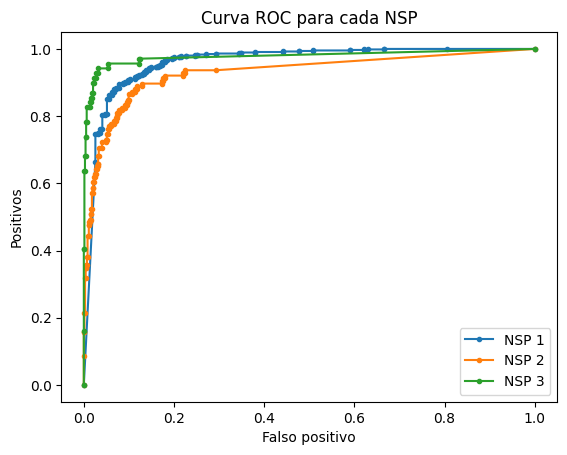

In [100]:
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob_bin[:, i])
    plt.plot(fpr, tpr, marker='.', label=f'NSP {i + 1}')

plt.xlabel('Falso positivo')
plt.ylabel('Positivos')
plt.title('Curva ROC para cada NSP')
plt.legend(loc='best')
plt.show()